## Outline

##### Paper

Frey, Dueck (2007) <i>Clustering by Passing Messages Between Data Points</i>

##### Overview
- Clustering algorithm
- Each data point is node in network
- Messages sent between nodes
- Data points have "affinity" for neighbors as "exemplars" (similar to cluster centroids)
- Exemplars are iteratively chosen through message-passing procedure between data points

##### Input
- Input is similarity $s(i, k)$ for points $i$ and $k$...
    - i.e. $s(i, k) = -\Vert x_i - x_k \Vert^2$
    
    
- ...and "preferences" $s(k, k)$
    - Diagonal elements of $s$-matrix
    - Larger $s(k, k) \rightarrow$ more likely to be chosen as exemplar
    - Under equal prior preference for all points, scale of shared value determines # of clusters
    
##### Algorithm Setup
- Two types of messages are passed
    1. "Responsibility" $r(i, k)$ from $i$ to $k$
        - "...accumulated evidence for how well-suited point $k$ is to serve as the exemplar for point $i$..."
        - Accounts for other potential exemplars for $i$
    2. "Availability" $a(i, k)$ from $k$ to $i$
        - "...accumulated evidence for how appropriate it would be for point $i$ to choose point $k$ as its exemplar..."
        - Accounts for support from other points that point $k$ should be an exemplar
        - Initialize $a(i, k) = 0$
        
##### Algorithm Steps
- At each step...
    1. Update responsibility:
    $$r(i, k) \leftarrow s(i, k) - \underset{k' \text{s.t.} k' \neq k}{\max} \left\{ a(i, k') + s(i, k') \right\}$$
    
    2. Update availability for $i \neq k$:
    $$a(i, k) \leftarrow \min \left\{ 0, r(k, k) + \hspace{-15px} \sum\limits_{i' \text{s.t.} i' \not\in \{i, k\}} \hspace{-10px} \max \{0, r(i', k)\} \right\}$$
    
    3. Update self-availability:
    $$a(k, k) \leftarrow \hspace{-15px} \sum\limits_{i' \text{s.t.} i' \neq k} \hspace{-10px} \max \{0, r(i', k)\}$$
    
    4. Assign exemplars:
        - For point $i$, the value of $k$ that maximizes $a(i, k) + r(i, k)$ either...
            - If $i=k$, identifies $i$ as an exemplar
            - If $i \neq k$, identifies $k$ as the exemplar for point $i$
        
    
- Algorithm may terminate after...
    - Fixed iterations
    - Changes in messages fall below threshold
    - Local decisions stay constant for a number of iterations
    
    
- Apply damping to messages
    - Avoids oscillations
    - Each message is $\lambda$ times previous value plus $1-\lambda$ times update value
        - $\lambda \in [0, 1]$ with default $\lambda = 0.5$
        

- In summary, AP consists of the following steps:
    1. Updating all responsibilities given availabilities
    2. Updating all availabilities given responsibilities
    3. Combining availabilities and responsibilities to monitor exemplar decisions
    4. Terminate algorithm if stopping condition met, otherwise go to 1.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from numba import njit, prange

In [2]:
np.random.seed(1234)

size = 100

# cluster 1
c1 = np.random.multivariate_normal(
    mean=np.array([0, -0.5]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# cluster 2
c2 = np.random.multivariate_normal(
    mean=np.array([1, -10]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# cluster 3
c3 = np.random.multivariate_normal(
    mean=np.array([2, 1]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# combined data
c = np.r_[c1, c2, c3]

# sample size
n = len(c)

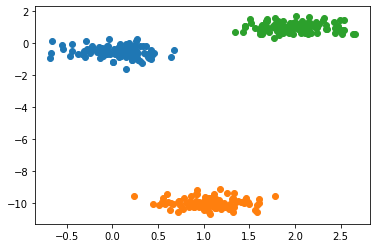

In [3]:
# separate clusters
plt.scatter(*c1.T)
plt.scatter(*c2.T)
plt.scatter(*c3.T)
plt.show()

In [4]:
# preference and similarity
p = -1. * np.ones(n)
s = -distance_matrix(c, c) + np.diag(p)

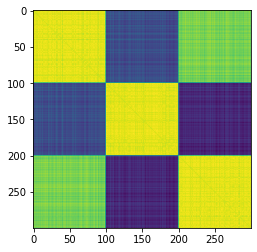

In [5]:
plt.imshow(s)
plt.show()

In [6]:
def update_responsibility_naive(r, s, a, lmb=0.5):
    """Naive responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    for i in range(n):
        for k in range(n):
            max_sum = np.max(np.delete(a[i, :] + s[i, :], k))
            r[i, k] = lmb * r[i, k] + (1 - lmb) * (s[i, k] - max_sum)
    return r

In [7]:
@njit(parallel=True)
def update_responsibility_numba(r, s, a, lmb=0.5):
    """Numba responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    for i in prange(n):
        for k in prange(n):
            max_sum = np.max(np.delete(a[i, :] + s[i, :], k))
            r[i, k] = lmb * r[i, k] + (1 - lmb) * (s[i, k] - max_sum)
    return r

In [8]:
def update_responsibility_numpy(r, s, a, lmb=0.5):
    """Numpy optimized responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    i = np.arange(n)
    temp = np.add(a, s)
    
    # indices of two largest row vals
    idx = np.argpartition(temp, -2)[:, [-1, -2]]
    idx_1 = idx[:, 0]
    idx_2 = idx[:, 1]
    
    # two largest row vals
    max_1 = temp[i, idx_1]
    max_2 = temp[i, idx_2]
    
    # compute responsibility
    np.subtract(s, max_1[:, None], temp)
    temp[i, idx_1] = s[i, idx_1] - max_2
    
    return r * lmb + (1-lmb) * temp

In [9]:
def update_availability_naive(r, a, lmb=0.5):
    """Naive availability matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        a (np.ndarray) : updated availability matrix
    """
    n = len(s)
    for i in range(n):
        for k in range(n):
            if(i == k):
                a_ik = np.sum(np.maximum(0,np.delete(r[:, k], k)))
            else:
                a_ik = np.minimum(0,r[k,k]+ np.sum(np.maximum(0,np.delete(r[:, k], (i,k)))))
            a[i, k] = lmb * a[i, k] + (1 - lmb) * (a_ik)
    return a

In [10]:
@njit(parallel=True)
def update_availability_numba(r, a, lmb=0.5):
    """Naive availability matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        a (np.ndarray) : updated availability matrix
    """
    n = len(r)
    for i in prange(n):
        for k in prange(n):
            if(i == k):
                a_ik = np.sum(np.maximum(0,np.delete(r[:, k], k)))
            elif(i < k ):
                vec= np.delete(r[:, k], k)
                sum_vec = np.delete(vec,i)
                a_ik = np.minimum(0,r[k,k]+ np.sum(np.maximum(0,sum_vec)))
            else:
                vec= np.delete(r[:, k], i)
                sum_vec = np.delete(vec,k)
                a_ik = np.minimum(0,r[k,k]+ np.sum(np.maximum(0,sum_vec)))
            a[i, k] = lmb * a[i, k] + (1 - lmb) * (a_ik)
    return a

In [11]:
def update_availability_numpy(r, a, lmb=0.5):
    """Numpy optimized availability matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        a (np.ndarray) : updated availability matrix
    """
    n = len(r)
    temp = np.zeros((n, n))
    max_r = np.maximum(r, 0)
    
    # set diag to r's diag to account for r(k, k) in sum
    np.fill_diagonal(max_r, np.diag(r))
    
    # removes i'=i from col sum
    colsum = np.sum(max_r, axis=0)
    max_r = np.subtract(colsum, max_r)
    temp = np.minimum(max_r, 0)
    
    # fill diag w/ self-availability
    np.fill_diagonal(temp, np.diag(max_r))
    
    return a * lmb + (1-lmb) * temp

In [12]:
a = np.zeros((n, n))
r = np.zeros_like(a)

# naive implementation
# %timeit -r3 -n5 update_responsibility_naive(r, s, a)
# print()

# numba implementation
# %timeit -r3 -n5 update_responsibility_numba(r, s, a)
# print()

# numpy implementation
%timeit -r3 -n5 update_responsibility_numpy(r, s, a)

1.42 ms ± 82.7 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [13]:
a = np.zeros((n, n))
r = np.zeros_like(a)

# naive implementation
# %timeit -r3 -n5 update_availability_naive(r, a)
# print()

# numba implementation
# %timeit -r3 -n5 update_availability_numba(r, a)
# print()

# numpy implementation
%timeit -r3 -n5 update_availability_numpy(r, a)

1.29 ms ± 4.19 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [14]:
# preference and similarity
p = -10 * np.ones(n)
s = -distance_matrix(c, c) + np.diag(p)

In [24]:
from aff_prop.aff_prop import resp_dense, aval_dense, affinity_propagation

In [29]:
def message_clusters(s, tol=1e-6, max_iter=100,return_iters = False,):
    """Performs affinity propagation clustering.
    
    Parameters:
        s (np.ndarray)        : similarity matrix of all pair-wise data
                                point comparisons
        tol (float)           : the tolerance used as a stopping condition
        max_iter (int)        : the maximum iterations stopping condition
        return_iters (boolean): if true returns the iterations used for output
    
    Returns:
        total_evidence (np.ndarray) : matrix of total evidence a point is an exemplar
        k (int)                     : the number of exemplars
        exemplars (np.ndarray): the indicies of the exemplars
        labels (np.ndarray)         : the index (in exemplar_points) of each points exemplar
        i (int)                     : the number of iterations needed to reach the output

    """
    n = len(s)
    r = np.zeros((n, n))
    a = np.zeros_like(r)
    stop = 0
    exemplars = np.zeros(n)
    
    for i in range(max_iter):
        old_messages = r+a
        r = update_responsibility_numpy(r, s, a)
        a = update_availability_numpy(r, a)

        #tolerance stopping condition
        if(np.all(np.abs(old_messages-(r+a)) < tol)):
            break

        #same exemplars 10 times stopping condition
        #The column index where the max occurs in each row
        exemplars_new = np.argmax(r+a, axis=1)
        if np.all(exemplars_new == exemplars):
            stop = stop + 1
            if(stop == 10):
                break
        else:
            stop = 0
        exemplars = exemplars_new

    exemplars = np.argmax(r+a, axis=1)
    exemplars,labels = np.unique(exemplars,return_inverse= True)
    k = len(exemplars)
    total_evidence = r+a
    
    if(return_iters):
        return (total_evidence, k, exemplars,labels, i)
    else:
        return (total_evidence, k, exemplars,labels)

In [31]:
%timeit -r5 -n5 affinity_propagation(s)
%timeit -r5 -n5 message_clusters(s)

152 ms ± 1.37 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
190 ms ± 8.15 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [25]:
k, exems, labels, ev, i = affinity_propagation(s)
print(ev)

[[ -6.90666817  -6.00178485  -0.61564065 ...  -3.56924407  -4.85747246
  -11.61247274]
 [ -6.91418547  -5.7319804   -0.37525555 ...  -2.89755154  -4.18429553
  -10.94068366]
 [-18.17108919 -17.01830346  11.39459046 ... -14.09248572 -15.43018231
  -22.10941235]
 ...
 [ -9.36902019  -7.78492705  -2.33681331 ...  -0.95725156  -3.16772462
   -9.18707039]
 [ -8.54153265  -6.9559551   -1.55879397 ...  -1.14613867  -2.90926852
   -9.08878971]
 [ -9.775171    -8.1909813   -2.71666208 ...  -1.54999252  -3.56742777
   -8.5034349 ]]
Wall time: 197 ms


In [26]:
def message_cluster_plot(X,exemplars,labels,param_x=0,param_y=1):
    """Plots affinity propagation clustering in 2D. Use outputs from
       message_clusters().
    
    Parameters:
        X (np.ndarray)        : the data that was clustered
        exemplars (np.ndarray): points to be used as exemplars
        labels (np.ndarray)   : label corresponding to each points' exemplar
        param_x (int)         : the column index of the paramater used as the X value
        param_y (int)         : the column index of the paramater used as the Y value
    """
    plt.scatter(X[:,param_x],X[:,param_y],c = labels, cmap = "viridis")
    plt.scatter(X[exemplars,param_x],X[exemplars,param_y],c = "red")
    

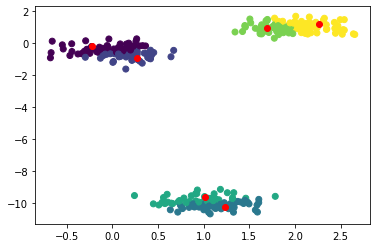

In [27]:
message_cluster_plot(c,exems,labels,0,1)